In [ ]:
# Importação das bibliotecas necessárias para manipulação de dados, criação de modelo e visualização
import torch
from torch import nn,optim
import numpy as np
import itertools
import matplotlib.pyplot as plt
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader

In [ ]:
# Definição dos hiperparâmetros do modelo e configuração do dispositivo (GPU ou CPU)

args = {
    "batch_size": 20,
    "num_workers":4,
    "num_classes":10,
    "lr": 1e-6,
    "weight_decay": 1e-4,
    "num_epochs": 30
}

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [ ]:
torch.manual_seed(42)

In [ ]:
# Carregamento do dataset CIFAR-10 com transformação em tensores
train_set = datasets.CIFAR10('./',
                             train=True,
                             transform=transforms.ToTensor(), #Usar RandomCrop() para pegar pedaços recortados
                             target_transform=None,
                             download=True)
test_set = datasets.CIFAR10('./',
                             train=False,
                             transform=transforms.ToTensor(),
                             target_transform=None,
                             download=False)

100%|██████████| 170M/170M [00:01<00:00, 104MB/s]


In [ ]:
print("Train set len : " + str(len(train_set)) + "\n Test set : " + str(len(test_set)))

Train set len : 50000
 Test set : 10000


In [ ]:
print(len(train_set.classes))

10


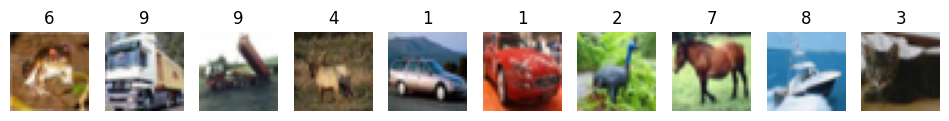

In [ ]:
# Carregamento do dataset CIFAR-10 com transformação em tensores
def plot_images(dataset,num_images=10):
  fig,axes = plt.subplots(1,num_images,figsize=(12,12))
  for i in range(num_images):
    image,label = dataset[i]
    image = image.permute(1, 2, 0)  #Correção dos pontos da imagem
    axes[i].imshow(image)
    axes[i].set_title(label)
    axes[i].axis('off')
  plt.show()
plot_images(train_set)

In [ ]:
#DataLoader -> Separa o data set em batches /randomiza os dados /carrega batches em paralelo usando threads
train_loader = DataLoader(train_set,batch_size=args["batch_size"],shuffle=True,num_workers=args["num_workers"])
test_loader = DataLoader(test_set,batch_size=args["batch_size"],shuffle=True,num_workers=args["num_workers"])

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


torch.Size([20, 3, 32, 32]) torch.Size([20])


Text(0.5, 1.0, 'Label :tensor(6)')

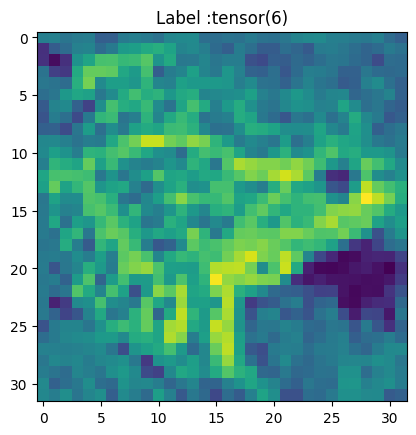

In [ ]:
#As amostras precisam ser tensores pois se não o código quebrará
for batch in train_loader:
  image,label = batch
  print(image.shape,label.shape)
  break
plt.imshow(image[0][0])
plt.title('Label :' + str(label[0]) )
  #print resultará em torch.Size == 20 batches/ 3 é o número de canais da imagem == RGB(Red,Blue,Green) / 32 de largura e altura

In [ ]:
# Definição do modelo de classificação com camadas lineares e ReLU
# O modelo recebe uma imagem achatada como entrada (32x32x3) e retorna probabilidades para 10 classes
class CIFARclassificator(nn.Module):
  def __init__(self,input_size,hidden_size,output):
    super(CIFARclassificator,self).__init__()
    self.layers = nn.Sequential(
        nn.Linear(in_features=input_size,out_features=hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size,hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size,output)
    )
    self.softmax = nn.Softmax(dim=1)
  def forward(self,X):
      X = X.view(X.size(0),-1)
      activation = self.layers(X)
      return self.softmax(activation)

Epoch : 1 
 Loss : 2.1683  0.0929
Epoch : 2 
 Loss : 2.1136  0.0937
Epoch : 3 
 Loss : 2.0967  0.0967
Epoch : 4 
 Loss : 2.0867  0.0991
Epoch : 5 
 Loss : 2.0770  0.0995
Epoch : 6 
 Loss : 2.0676  0.0996
Epoch : 7 
 Loss : 2.0602  0.1011
Epoch : 8 
 Loss : 2.0571  0.1019
Epoch : 9 
 Loss : 2.0533  0.1020
Epoch : 10 
 Loss : 2.0472  0.1020
Epoch : 11 
 Loss : 2.0456  0.1015
Epoch : 12 
 Loss : 2.0419  0.1053
Epoch : 13 
 Loss : 2.0410  0.1075
Epoch : 14 
 Loss : 2.0402  0.1079
Epoch : 15 
 Loss : 2.0397  0.1087
Epoch : 16 
 Loss : 2.0377  0.1084
Epoch : 17 
 Loss : 2.0430  0.1085
Epoch : 18 
 Loss : 2.0356  0.1090


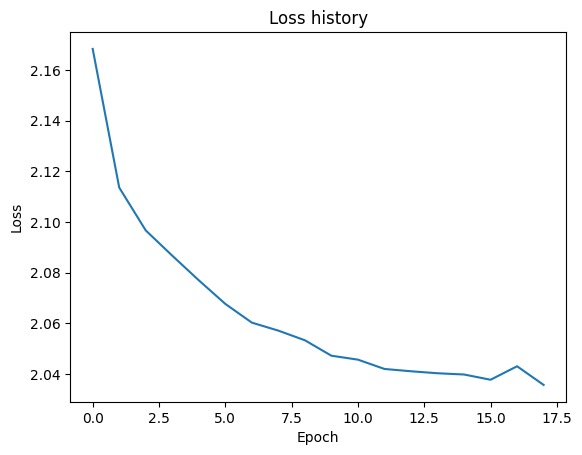

In [12]:
# Uso da função de perda CrossEntropyLoss e do otimizador Adam
# Função que realiza o treinamento do modelo por várias épocas
# Inclui forward pass, cálculo de perda, backward pass e atualização dos pesos

input_size = 32*32*3 #Image size
hidden_size = 128
output = 10 #Number of classes (10)
model = CIFARclassificator(input_size=32*32*3,hidden_size=128,output=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=model.parameters(),lr=0.001)

def train_model(model,train_loader,criterion,optimizer,num_epochs=17):
  loss_history = []
  for epoch in range(num_epochs + 1):
      epoch_loss = []
      model.train() #Train mode model

      for batch in train_loader:
        #Cast on GPU
          image,label = batch
          image = image.to(device)
          label = label.to(device)

        #Foward
          predict = model(image)
          loss = criterion(predict,label)
          epoch_loss.append(loss.cpu().item())
        #Backward -> Gradients calculum
          optimizer.zero_grad() #Init with zero
          loss.backward()
          optimizer.step()

      epoch_loss = np.asarray(epoch_loss)
      mean_loss = np.mean(epoch_loss)
      loss_history.append(mean_loss)
      print(f"Epoch : {epoch + 1} \n Loss : {epoch_loss.mean():.4f}  {epoch_loss.std():.4f}")
#Plot da função
  plt.plot(loss_history)
  plt.title("Loss history")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.show()

train_model(model,train_loader,criterion,optimizer)